# Crime and Housing

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# load data sets
crime = pd.read_csv('crime-housing-austin-2015.csv')
population = pd.read_csv('AustinZipCodes.csv')

# clean columns and set to float data types
population['Population'] = population['Population'].str.replace(",", "").astype('float')
population['People / Sq. Mile'] = population['People / Sq. Mile'].str.replace(",", "").astype('float')
population[['Latitude', 'Longitude']] = population['Location'].str.split(',', n=1, expand=True).astype('float')

# remove rows where no Zip Code is given and convert to integers
crime = crime.dropna(subset='Zip_Code_Crime')
crime['Zip_Code_Crime'] = crime['Zip_Code_Crime'].astype(np.int64)

# count the number of crimes per zip code
crime_counts = crime.groupby('Zip_Code_Crime', as_index=False).agg({'Key':'count', 
                                                     'Medianhouseholdincome':'first', 
                                                     'Medianrent':'first', 
                                                     'Medianhomevalue':'first'}).rename(columns={'Key':'Count'})

# merge crime and population with demographics
crime_rate = pd.merge(crime_counts, population, left_on="Zip_Code_Crime", right_on='Zip Code', how='inner')
crime_rate['Crime_Rate'] = crime_rate.Count / crime_rate.Population * 100000

# # clean columns and set to float data types
crime_rate['Medianhomevalue'] = crime_rate['Medianhomevalue'].str.replace("$", "").astype('float')
crime_rate['Medianrent'] = crime_rate['Medianrent'].str.replace("$", "").astype('float')
crime_rate['Medianhouseholdincome'] = crime_rate['Medianhouseholdincome'].str.replace("$", "").astype('float')

# remove ZIP code 78701 as outlier
crime_rate = crime_rate.drop([0])
crime_rate.head(10)

,Zip_Code_Crime,Count,Medianhouseholdincome,Medianrent,Medianhomevalue,#,Zip Code,Location,City,Population,People / Sq. Mile,National Rank,Latitude,Longitude,Crime_Rate
1,78702,1668,34734.0,766.0,175400.0,8,78702,"30.263909, -97.714495","Austin, Texas",22534.0,4501.98,"#2,015",30.263909,-97.714495,7402.147865
2,78703,738,92606.0,1183.0,621900.0,13,78703,"30.294204, -97.765114","Austin, Texas",19585.0,3491.54,"#2,753",30.294204,-97.765114,3768.189941
3,78704,2571,50248.0,940.0,338200.0,6,78704,"30.243128, -97.765874","Austin, Texas",43249.0,5001.96,"#1,713",30.243128,-97.765874,5944.646119
4,78705,1346,11917.0,1088.0,292500.0,1,78705,"30.293474, -97.738268","Austin, Texas",26825.0,11008.66,#519,30.293474,-97.738268,5017.707363
5,78717,237,93305.0,1018.0,243200.0,27,78717,"30.488309, -97.764829","Austin, Texas",8148.0,1081.05,"#6,119",30.488309,-97.764829,2908.689249
6,78719,186,NaN,NaN,NaN,43,78719,"30.184794, -97.682619","Austin, Texas",1765.0,93.88,"#14,377",30.184794,-97.682619,10538.243626
7,78721,482,32131.0,870.0,121000.0,19,78721,"30.269811, -97.683126","Austin, Texas",10124.0,2568.43,"#3,690",30.269811,-97.683126,4760.964046
8,78722,332,44917.0,930.0,265100.0,20,78722,"30.293272, -97.709068","Austin, Texas",6365.0,2567.53,"#3,692",30.293272,-97.709068,5216.025137
9,78723,2124,41869.0,817.0,176500.0,5,78723,"30.305341, -97.683344","Austin, Texas",30110.0,5175.95,"#1,640",30.305341,-97.683344,7054.134839
10,78724,562,35711.0,962.0,105700.0,30,78724,"30.297099, -97.617767","Austin, Texas",15428.0,555.85,"#7,870",30.297099,-97.617767,3642.727508


# Overall Crime Rate Correlated with Financial Health

In [3]:
# drop NaN value in financial health metrics
crime_rate_dropna = crime_rate.dropna(subset='Medianhouseholdincome')
crime_rate_dropna = crime_rate_dropna.dropna(subset='Medianrent')
crime_rate_dropna = crime_rate_dropna.dropna(subset='Medianhomevalue')
crime_rate_dropna.head()

,Zip_Code_Crime,Count,Medianhouseholdincome,Medianrent,Medianhomevalue,#,Zip Code,Location,City,Population,People / Sq. Mile,National Rank,Latitude,Longitude,Crime_Rate
1,78702,1668,34734.0,766.0,175400.0,8,78702,"30.263909, -97.714495","Austin, Texas",22534.0,4501.98,"#2,015",30.263909,-97.714495,7402.147865
2,78703,738,92606.0,1183.0,621900.0,13,78703,"30.294204, -97.765114","Austin, Texas",19585.0,3491.54,"#2,753",30.294204,-97.765114,3768.189941
3,78704,2571,50248.0,940.0,338200.0,6,78704,"30.243128, -97.765874","Austin, Texas",43249.0,5001.96,"#1,713",30.243128,-97.765874,5944.646119
4,78705,1346,11917.0,1088.0,292500.0,1,78705,"30.293474, -97.738268","Austin, Texas",26825.0,11008.66,#519,30.293474,-97.738268,5017.707363
5,78717,237,93305.0,1018.0,243200.0,27,78717,"30.488309, -97.764829","Austin, Texas",8148.0,1081.05,"#6,119",30.488309,-97.764829,2908.689249


In [4]:
# these are the ZIP codes that were dropped in case you're curious
crime_rate[crime_rate.isnull().any(axis=1)]

,Zip_Code_Crime,Count,Medianhouseholdincome,Medianrent,Medianhomevalue,#,Zip Code,Location,City,Population,People / Sq. Mile,National Rank,Latitude,Longitude,Crime_Rate
6,78719,186,NaN,NaN,NaN,43,78719,"30.184794, -97.682619","Austin, Texas",1765.0,93.88,"#14,377",30.184794,-97.682619,10538.243626
11,78725,45,NaN,NaN,NaN,42,78725,"30.228676, -97.594967","Austin, Texas",1836.0,116.87,"#13,282",30.228676,-97.594967,2450.980392
19,78733,1,NaN,NaN,NaN,32,78733,"30.323857, -97.894860","Austin, Texas",8716.0,510.92,"#8,116",30.323857,-97.894860,11.473153
21,78736,71,NaN,NaN,NaN,40,78736,"30.250877, -97.968810","Austin, Texas",6897.0,187.88,"#11,301",30.250877,-97.968810,1029.433087
22,78737,4,NaN,NaN,NaN,41,78737,"30.177041, -97.956661","Austin, Texas",7100.0,143.90,"#12,372",30.177041,-97.956661,56.338028
29,78747,275,NaN,NaN,NaN,39,78747,"30.122470, -97.746210","Austin, Texas",5079.0,194.02,"#11,173",30.122470,-97.746210,5414.451664


## Crime Rate vs. Median Household Income

PearsonRResult(statistic=-0.6583575925756773, pvalue=2.3126276203441627e-05)

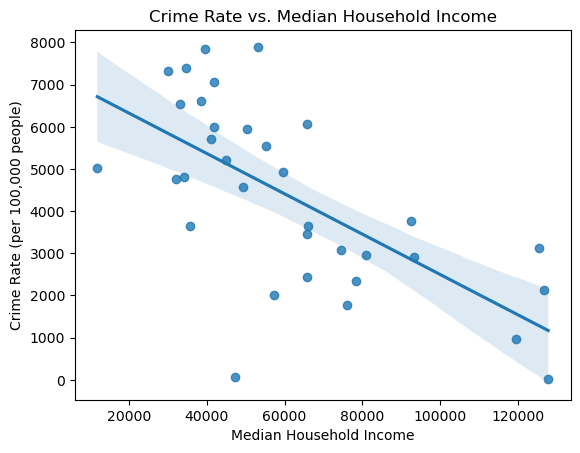

In [5]:
crime_vs_income = sns.regplot(data=crime_rate_dropna, x='Medianhouseholdincome', y='Crime_Rate')
crime_vs_income.set(title='Crime Rate vs. Median Household Income', xlabel='Median Household Income', ylabel='Crime Rate (per 100,000 people)')
stats.pearsonr(crime_rate_dropna.Medianhouseholdincome, crime_rate_dropna.Crime_Rate)

## Crime Rate vs. Median Rent

PearsonRResult(statistic=-0.5526589116740486, pvalue=0.0007006143274077552)

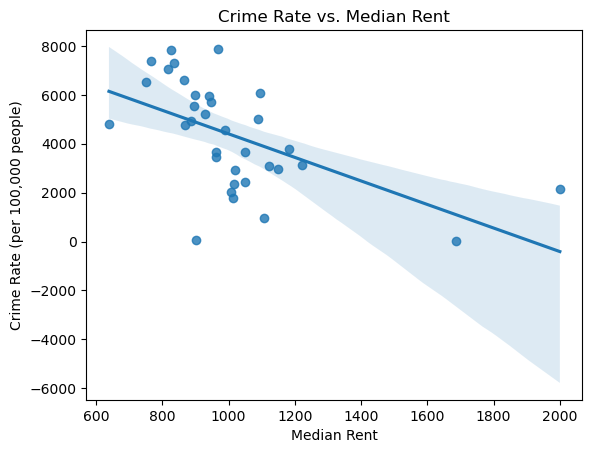

In [6]:
crime_vs_rent = sns.regplot(data=crime_rate_dropna, x='Medianrent', y='Crime_Rate')
crime_vs_rent.set(title='Crime Rate vs. Median Rent', xlabel='Median Rent', ylabel='Crime Rate (per 100,000 people)')
stats.pearsonr(crime_rate_dropna.Medianrent, crime_rate_dropna.Crime_Rate)

## Crime Rate vs. Median Home Value

PearsonRResult(statistic=-0.45440739160137295, pvalue=0.0069393713621015585)

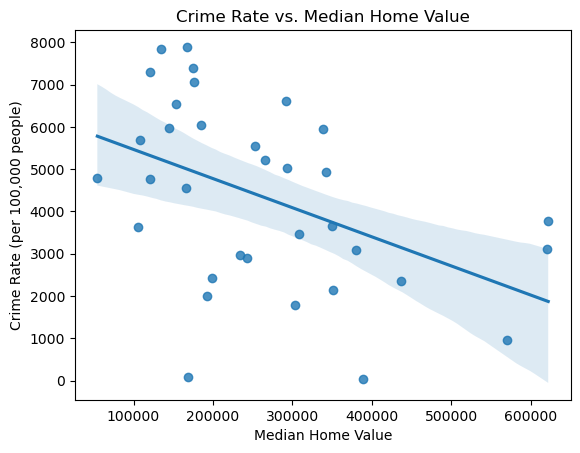

In [7]:
crime_vs_home_value = sns.regplot(data=crime_rate_dropna, x='Medianhomevalue', y='Crime_Rate')
crime_vs_home_value.set(title='Crime Rate vs. Median Home Value', xlabel='Median Home Value', ylabel='Crime Rate (per 100,000 people)')
stats.pearsonr(crime_rate_dropna.Medianhomevalue, crime_rate_dropna.Crime_Rate)

## Crime Rate vs. Population Density

PearsonRResult(statistic=0.39758566307702037, pvalue=0.01106909826071153)

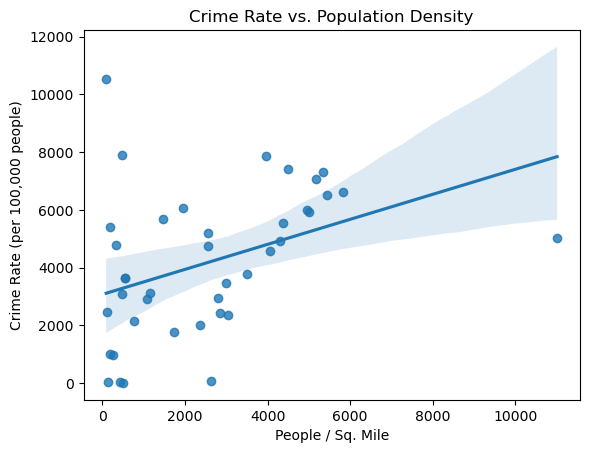

In [8]:
crime_rate = crime_rate.rename(columns={'People / Sq. Mile': 'people_per_sq_mile'})
crime_vs_pop_density = sns.regplot(data=crime_rate, x='people_per_sq_mile', y='Crime_Rate')
crime_vs_pop_density.set(title='Crime Rate vs. Population Density', xlabel='People / Sq. Mile', ylabel='Crime Rate (per 100,000 people)')
stats.pearsonr(crime_rate.people_per_sq_mile, crime_rate.Crime_Rate)

# T-Test Comparisons of Low vs High Income Zip Codes

To divide Zip Codes into lower or higher income areas, we used the Department of Housing and Urban Development's (HUD) definition of lower income, which is below 80% of the median income for the metropolitain area. The median household income for Austin, TX in 2015 was \\$57,689, which sets our threshold at \\$46,151.20. The median household income of each Zip Code was then compared as either above or below this threshold. 

In [9]:
crime_rate['relativeIncome'] = np.where(crime_rate['Medianhouseholdincome'] > 46151.2, 'above', 'below')
crime_rate.value_counts('relativeIncome')

relativeIncome
above    21
below    19
Name: count, dtype: int64

## Where are the approximate locations of Above income or Below income?

<Axes: xlabel='Longitude', ylabel='Latitude'>

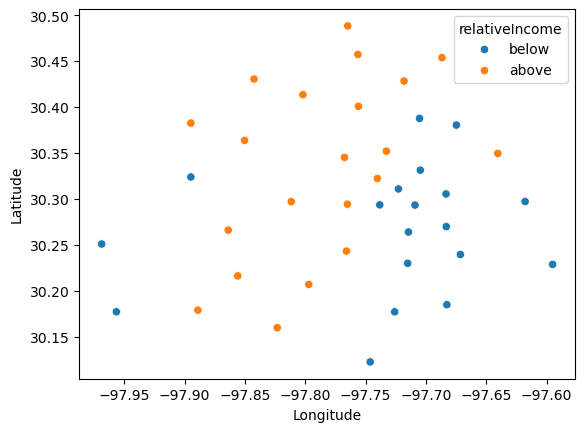

In [10]:
sns.scatterplot(data=crime_rate, x='Longitude', y='Latitude', hue='relativeIncome')

## Distribution of Crime Rate by Relation to HUD Threshold

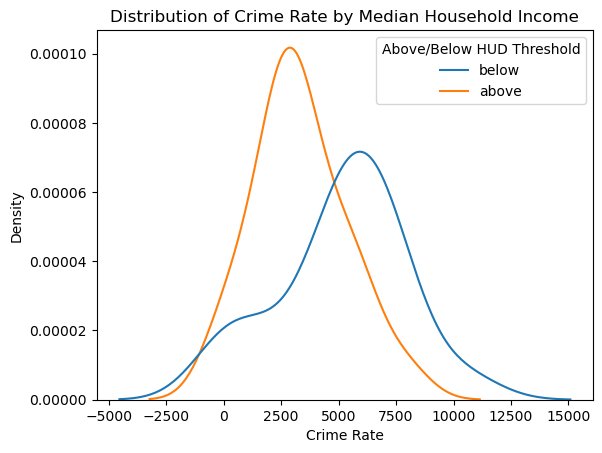

In [11]:
relIncome_crime_dis = sns.kdeplot(data=crime_rate[crime_rate.Zip_Code_Crime != 78701], x='Crime_Rate', hue='relativeIncome')
relIncome_crime_dis.set(title='Distribution of Crime Rate by Median Household Income', xlabel = 'Crime Rate')
relIncome_crime_dis.get_legend().set_title('Above/Below HUD Threshold') 
plt.savefig("relativeIncome.png", bbox_inches='tight')

## Is the difference statistically significant?

In [12]:
high_income = crime_rate.loc[(crime_rate.Zip_Code_Crime != 78701) & (crime_rate.relativeIncome == 'above'), 'Crime_Rate']
low_income = crime_rate.loc[(crime_rate.Zip_Code_Crime != 78701) & (crime_rate.relativeIncome == 'below'), 'Crime_Rate']
stats.ttest_ind(high_income, low_income)

TtestResult(statistic=-2.410728548166748, pvalue=0.02086485746593844, df=38.0)

We have some evidence that the crime rate for Zip Codes with lower income is higher than for Zip Codes with lower incomes. 

## How big is the difference?

In [13]:
crime_rate.loc[crime_rate.Zip_Code_Crime != 78701, :].groupby('relativeIncome').agg({'Crime_Rate': ['min', 'max', 'mean', 'median', 'std']})

Crime_Rate                                                     
                      min           max         mean       median          std
relativeIncome                                                                
above           27.555800   7893.766138  3317.872506  3081.377314  1990.589222
below           11.473153  10538.243626  5126.165828  5414.451664  2728.704967

For 2015, the difference measured is about 1808 crimes per 100,000 people.